# NLP Sentiment Analysis

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Bidirectional,
    LSTM,
    Embedding,
    Flatten,
)

In [2]:
# Plot accuracy and loss
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()

## Preprocessing

In [4]:
# Read txt files
test_data = pd.read_csv('data/test.txt', delimiter = "\t", names=['sentence'])
train_data = pd.read_csv('data/train.txt', delimiter = "\t", names=['sentence'])

print(train_data.shape, test_data.shape)
print(train_data.head())

(16000, 1) (2000, 1)
                                            sentence
0                    i didnt feel humiliated;sadness
1  i can go from feeling so hopeless to so damned...
2  im grabbing a minute to post i feel greedy wro...
3  i am ever feeling nostalgic about the fireplac...
4                         i am feeling grouchy;anger


In [5]:
# Column for label
train_data['feeling'] = train_data['sentence'].str.split(';').str[1]
test_data['feeling'] = test_data['sentence'].str.split(';').str[1]

# Remove label part in feature
train_data['sentence'] = train_data['sentence'].str.split(';').str[0]
test_data['sentence'] = test_data['sentence'].str.split(';').str[0]

train_data.head()

,sentence,feeling
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
# Check null values
null_values_train = train_data.isnull().sum()
null_values_test = test_data.isnull().sum()

print("Train data:\n", null_values_train)
print("\nTest data:\n", null_values_test)

Train data:
 sentence    0
feeling     0
dtype: int64

Test data:
 sentence    0
feeling     0
dtype: int64


In [17]:
# Check unique labels
unique_label_train = train_data['feeling'].unique()
unique_label_test = test_data['feeling'].unique()

num_label = len(unique_label_train)

print(sorted(unique_label_train))
print(sorted(unique_label_test))

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


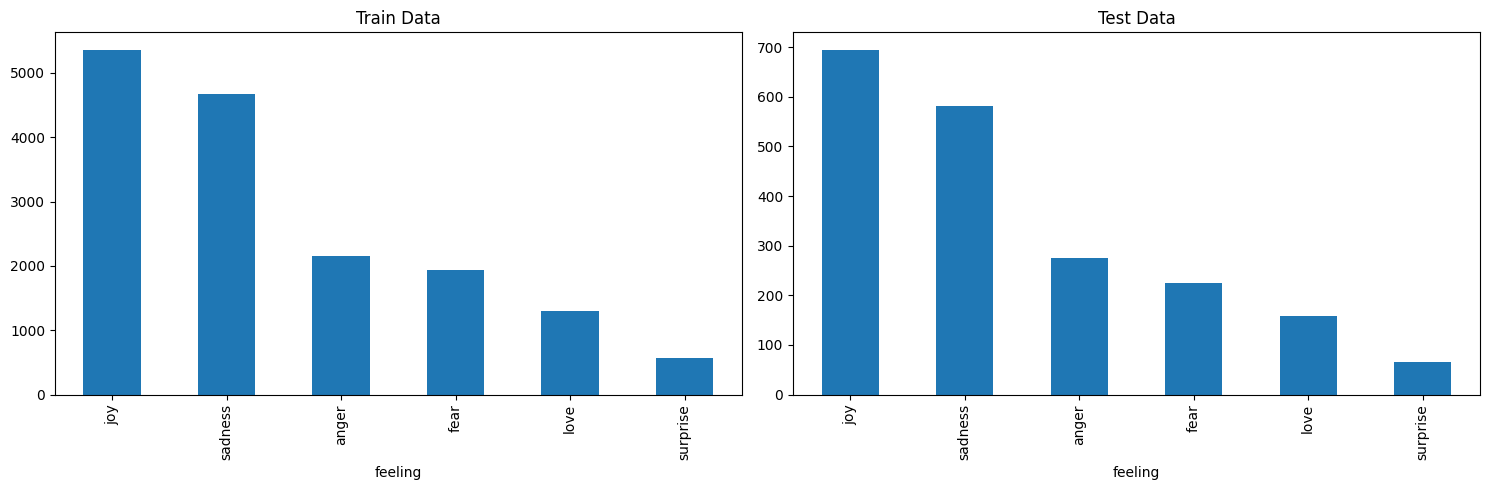

In [7]:
# Plot distribution of labels in train and test data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

train_data['feeling'].value_counts().plot(kind='bar', ax=axes[0], title='Train Data')
test_data['feeling'].value_counts().plot(kind='bar', ax=axes[1], title='Test Data')

plt.tight_layout()
plt.show()

In [6]:
# Convert to list
train_sentences = train_data['sentence'].tolist()
train_labels = train_data['feeling'].tolist()

test_sentences = test_data['sentence'].tolist()
test_labels = test_data['feeling'].tolist()
  
len(train_sentences), len(test_sentences)


(16000, 2000)

In [7]:
# One-Hot Encode labels
encoder = LabelEncoder()

train_labels_encoded = to_categorical(encoder.fit_transform(train_labels))
test_labels_encoded = to_categorical(encoder.transform(test_labels))

train_labels_encoded

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [8]:
# Tokenizer
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

print(len(train_sequences), len(test_sequences))
print(len(word_index))
print(list(word_index.items())[:10])

16000 2000
15213
[('<OOV>', 1), ('i', 2), ('feel', 3), ('and', 4), ('to', 5), ('the', 6), ('a', 7), ('feeling', 8), ('that', 9), ('of', 10)]


In [9]:
# Padding
max_length = 100

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

print(len(train_padded), len(test_padded))
print(len(train_padded[0]))
print(train_padded[0])

16000 2000
100
[  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


## Fully Connected Neural Network

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [44]:
# Model Definition with Embedding in first layer
embedding_dim = 50

model_nn = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_label, activation='softmax')
])

model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           500000    
                                                                 
 flatten_1 (Flatten)         (None, 5000)              0         
                                                                 
 dense_7 (Dense)             (None, 64)                320064    
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 6)                 198       
                                                                 
Total params: 822342 (3.14 MB)
Trainable params: 822342 (3.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# Training
num_epochs = 25

history_nn = model_nn.fit(
    train_padded, 
    train_labels_encoded, 
    epochs=num_epochs,
    batch_size=32, 
    validation_data=(test_padded, test_labels_encoded),
    callbacks=[early_stopping]
)

Epoch 1/25
500/500 [==============================] - 23s 43ms/step - loss: 1.4258 - accuracy: 0.4326 - val_loss: 1.0003 - val_accuracy: 0.6160
Epoch 2/25
500/500 [==============================] - 15s 30ms/step - loss: 0.6878 - accuracy: 0.7566 - val_loss: 0.5804 - val_accuracy: 0.8100
Epoch 3/25
500/500 [==============================] - 17s 35ms/step - loss: 0.2540 - accuracy: 0.9206 - val_loss: 0.4979 - val_accuracy: 0.8505
Epoch 4/25
500/500 [==============================] - 16s 33ms/step - loss: 0.0982 - accuracy: 0.9734 - val_loss: 0.5536 - val_accuracy: 0.8430
Epoch 5/25
500/500 [==============================] - 16s 33ms/step - loss: 0.0514 - accuracy: 0.9881 - val_loss: 0.5901 - val_accuracy: 0.8515
Epoch 6/25
500/500 [==============================] - 16s 33ms/step - loss: 0.0343 - accuracy: 0.9927 - val_loss: 0.6677 - val_accuracy: 0.8380


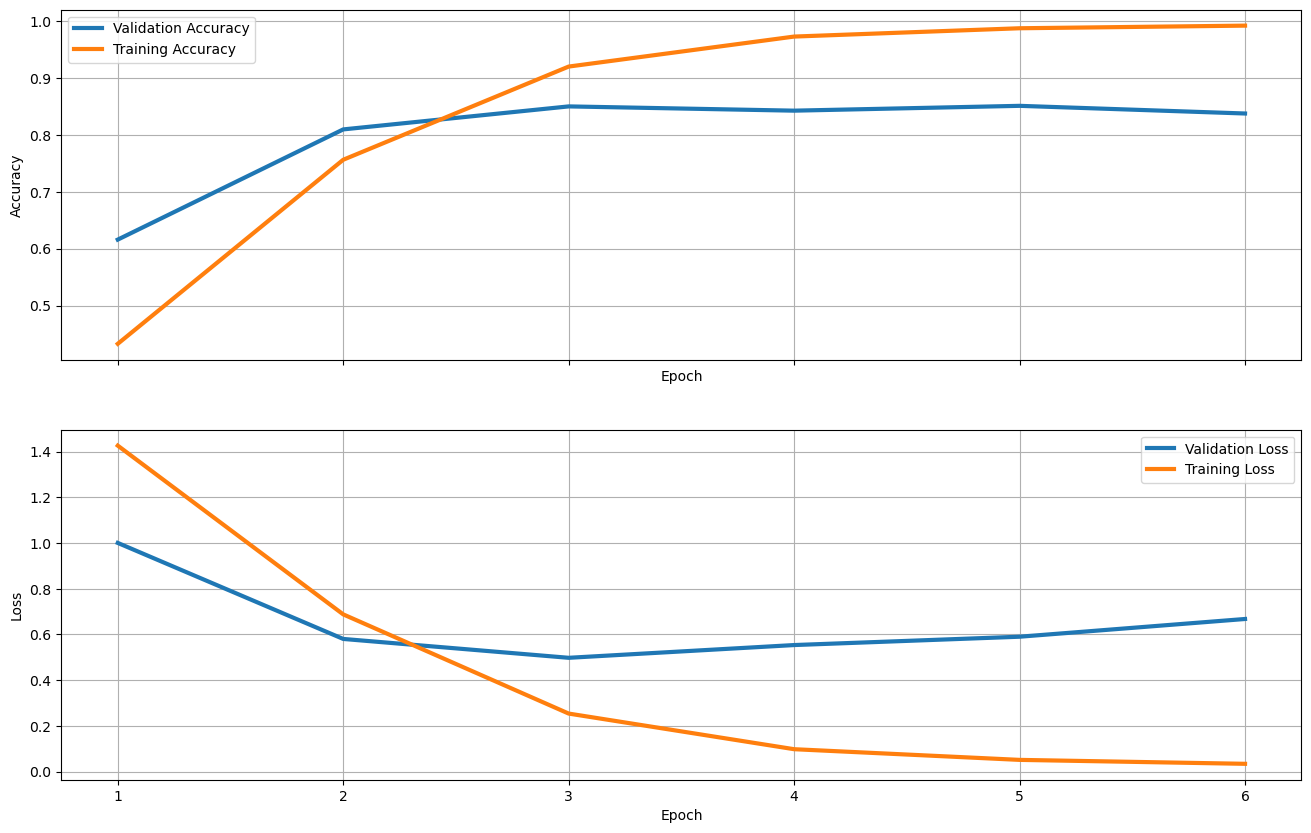

In [46]:
plot_results(history_nn)

In [47]:
# Save the model
model_nn.save('models/nn.h5')

/Users/raydi/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Recurent Neural Network (LSTM)

In [48]:
# Model Definition with LSTM and Embedding in the first layer
embedding_dim = 50

model_lstm = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(num_label, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 50)           500000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 100, 128)          58880     
 onal)                                                           
                                                                 
 dropout_41 (Dropout)        (None, 100, 128)          0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_42 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 16)               

In [49]:
# Training
num_epochs = 25

history_lstm = model_lstm.fit(
    train_padded, 
    train_labels_encoded, 
    epochs=num_epochs, 
    batch_size=32, 
    validation_data=(test_padded, test_labels_encoded),
    callbacks=[early_stopping]
)

Epoch 1/25
500/500 [==============================] - 55s 94ms/step - loss: 1.2462 - accuracy: 0.5017 - val_loss: 0.7651 - val_accuracy: 0.6705
Epoch 2/25
500/500 [==============================] - 41s 82ms/step - loss: 0.5585 - accuracy: 0.7945 - val_loss: 0.4181 - val_accuracy: 0.8650
Epoch 3/25
500/500 [==============================] - 43s 86ms/step - loss: 0.3134 - accuracy: 0.8979 - val_loss: 0.3501 - val_accuracy: 0.8860
Epoch 4/25
500/500 [==============================] - 48s 96ms/step - loss: 0.2043 - accuracy: 0.9360 - val_loss: 0.3214 - val_accuracy: 0.9025
Epoch 5/25
500/500 [==============================] - 41s 81ms/step - loss: 0.1484 - accuracy: 0.9534 - val_loss: 0.3021 - val_accuracy: 0.9050
Epoch 6/25
500/500 [==============================] - 40s 80ms/step - loss: 0.1202 - accuracy: 0.9618 - val_loss: 0.3142 - val_accuracy: 0.8995
Epoch 7/25
500/500 [==============================] - 40s 80ms/step - loss: 0.1011 - accuracy: 0.9679 - val_loss: 0.3130 - val_accuracy:

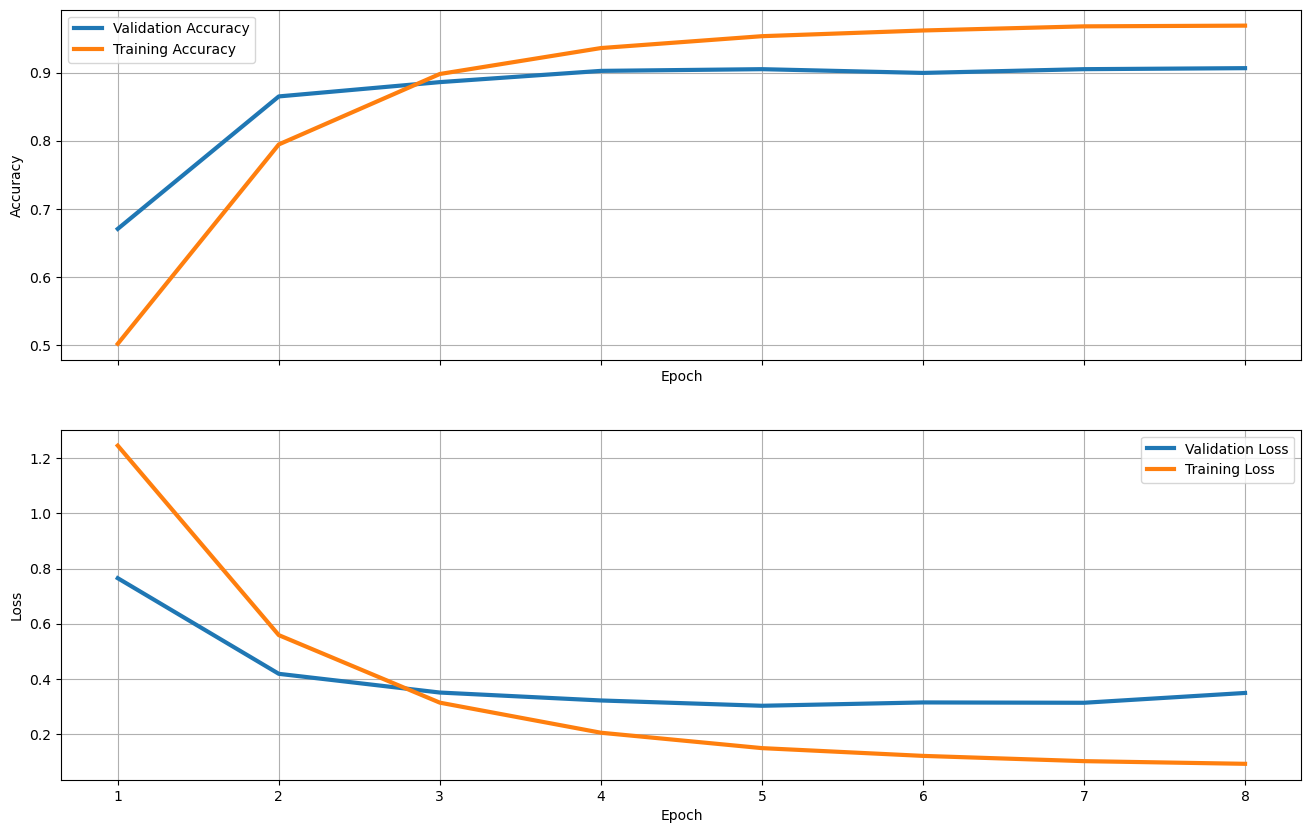

In [50]:
plot_results(history_lstm)

In [51]:
# Save the model
model_lstm.save('models/lstm.h5')

/Users/raydi/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Fine-tuned Transformer

In [11]:
from transformers import (
    BertTokenizer,
    TFBertModel,
)

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

2024-02-19 21:03:30.677840: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-19 21:03:30.677863: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-19 21:03:30.677873: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-19 21:03:30.678594: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-19 21:03:30.679014: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.b

In [14]:
# # Load the TensorFlow Hub model for preprocessing text data for BERT
# bert_preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# # Preprocess the train and test sentences using the BERT preprocessor
# train_inputs = bert_preprocessor(train_sentences)
# test_inputs = bert_preprocessor(test_sentences)

# # Convert the preprocessed inputs to TensorFlow tensors
# train_inputs = tf.constant(train_inputs['input_word_ids'])
# test_inputs = tf.constant(test_inputs['input_word_ids'])

# print(train_inputs.shape, test_inputs.shape)

In [13]:
train_inputs = []
train_masks = []

for sentence in train_sentences:
    encoded_sentence = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    train_inputs.append(encoded_sentence['input_ids'])
    train_masks.append(encoded_sentence['attention_mask'])

train_inputs = tf.concat(train_inputs, axis=0)
train_masks = tf.concat(train_masks, axis=0)

test_inputs = []
test_masks = []

for sentence in test_sentences:
    encoded_sentence = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    test_inputs.append(encoded_sentence['input_ids'])
    test_masks.append(encoded_sentence['attention_mask'])

test_inputs = tf.concat(test_inputs, axis=0)
test_masks = tf.concat(test_masks, axis=0)

print(train_inputs.shape, train_masks.shape)
print(test_inputs.shape, test_masks.shape)

(16000, 100) (16000, 100)
(2000, 100) (2000, 100)


In [14]:
bert_model.trainable = False

In [18]:
input_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model([input_ids, attention_mask])

net = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64, return_sequences=True)
)(bert_output[0])

net = tf.keras.layers.Dropout(0.3)(net)

net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(net)

net = tf.keras.layers.Dropout(0.3)(net)

net = tf.keras.layers.Dense(32, activation="relu")(net)

output = tf.keras.layers.Dense(num_label, activation="softmax")(net)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 100, 7                                       

In [20]:
model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [21]:
hist = model.fit(
    x=[train_inputs, train_masks],
    y=train_labels_encoded,
    epochs=10,
    batch_size=32,
    validation_data=([test_inputs, test_masks], test_labels_encoded),
    # callbacks=[early_stopping]
)

Epoch 1/10


2024-02-19 21:04:21.069328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


123/500 [======>.......................] - ETA: 3:20 - loss: 1.4982 - accuracy: 0.4271

KeyboardInterrupt: 

In [ ]:
plot_results(hist)

NameError: name 'hist' is not defined

In [21]:
model.save('models/bert.h5')

## Model comparison

1. To compare the performance between the three models, we can analyze their accuracy and loss plots. From the plots, we can observe the following:

* **Fully Connected Neural Network (NN)**: The NN model achieved a training accuracy of around 95% and a validation accuracy of around 84%. The loss decreased steadily during training, indicating that the model was learning. However, as the training loss continue to decrease the validation loss increase slightly, suggesting some overfitting. The early stopping callback was triggered to prevent overfitting.

* **Recurrent Neural Network with LSTM (LSTM)**: The LSTM model achieved a training accuracy of around 97% and a validation accuracy of around 90%. and the same pattern was seen with overfitting and the callback was triggered.

* **Fine-tuned Transformer (BERT)**: The BERT model achieved the highest training accuracy of around 98% and a validation accuracy of around 85%. The loss decreased rapidly during training, indicating that the model was learning quickly. The validation loss was also lower than the training loss, suggesting that the model was not overfitting.

 -> Based on these observations, the BERT model appears to be the best approach. It achieved the highest accuracy on both the training and validation sets and had the lowest loss. Additionally, the BERT model is a state-of-the-art model for natural language processing tasks and has been pre-trained on a large corpus of text data, allowing it to capture complex patterns and semantic relationships in the text.

2. From this exercise, we have learned several key points:

* **Preprocessing**: Preprocessing text data involves tasks such as tokenization, padding, and one-hot encoding. These steps are crucial for preparing the data for training machine learning models.

* **Model Selection**: Different models, such as fully connected neural networks, recurrent neural networks with LSTM, and fine-tuned transformers, can be used for sentiment analysis. Each model has its own strengths and weaknesses, and it is important to evaluate their performance on the specific task at hand.

* **Overfitting**: Overfitting occurs when a model performs well on the training data but fails to generalize to new, unseen data. It is important to monitor the validation loss and accuracy to detect signs of overfitting and take appropriate measures, such as early stopping or regularization techniques, to mitigate it.

* **Fine-tuning**: Fine-tuning a pre-trained model, such as BERT, can lead to improved performance. However, it may require further fine-tuning and experimentation to achieve the best possible results. Fine-tuning involves adjusting hyperparameters, modifying the model architecture, or using different training strategies.

Overall, this exercise has provided insights into the process of sentiment analysis, from data preprocessing to model building and evaluation. It highlights the importance of selecting the right model, monitoring performance metrics, and continuously iterating and improving the models to achieve better results.